In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

This is a template for your final project. 

In [2]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


# Part 1.

### Task formalization and Evaluation criteria

### 1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

In [3]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60198 entries, 0 to 60197
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          60198 non-null  object 
 1   title                  60198 non-null  object 
 2   original_title         60198 non-null  object 
 3   year                   60198 non-null  int64  
 4   date_published         60198 non-null  object 
 5   genre                  60198 non-null  object 
 6   duration               60198 non-null  int64  
 7   country                60193 non-null  object 
 8   language               59759 non-null  object 
 9   director               60174 non-null  object 
 10  writer                 59390 non-null  object 
 11  production_company     57454 non-null  object 
 12  actors                 60168 non-null  object 
 13  description            58205 non-null  object 
 14  avg_vote               60198 non-null  float64
 15  vo

Needless to say, the success of the film is determined by indicators calculated already upon the release of the film and after a certain period. We have several such indicators, let's list them:
 - avg_vote
 - votes
 - usa_gross_income
 - worlwide_gross_income
 - metascore
 - reviews_from_users
 - reviews_from_critics
 
The remaining signs are characteristics that can influence the success of the film.

Probably, it should also be said that we cannot use these indicators as features, because we have the task of "predicting the success of the film even before its release." And before the release, it is impossible to know for sure the amount of monetary fees, the number of reviews, rating and other indicators. It turns out that we can use them only as a target variable.

Now we need to understand which indicator or a bunch of indicators most accurately answers the question: is the film successful?

Find out the number of missing values in possible target variables. Let's count them as a percentage of the total number of films.

In [4]:
possible_target_variable = ['avg_vote',
                            'votes',
                            'usa_gross_income',
                            'worlwide_gross_income',
                            'metascore',
                            'reviews_from_users',
                            'reviews_from_critics']
full_dataset[possible_target_variable].isna().sum() / len(full_dataset) * 100

avg_vote                  0.000000
votes                     0.000000
usa_gross_income         80.245191
worlwide_gross_income    68.211568
metascore                85.361640
reviews_from_users        6.759361
reviews_from_critics     13.669889
dtype: float64

We can see that for the most part the missing values are observed in any of the possible columns of the target variable. And the missing values are up to 85%!

That's a lot. Provided that we have 60 thousand observations.

The question arises: can we, for example, donate 68% of the data and use "worlwide_gross_income" as the target variable? Or choose "meta" and lose 85% of the data?

After all, in fact, these are the resulting indicators that can reflect the success of the film. And they will reflect it much better than the "reviews_from_users" indicator.

Speaking of which, is it possible to select it as a target variable? We know that a large number of reviews arise as a result of some kind of resonance. For example, many people have watched a movie, they liked it, and they decided to recommend this movie to others through a review. Voila, a lot of positive comments, we can say that the film is successful. However, here's another example for you: the film was very much promoted, everyone was waiting for its release, and when it came out, it turned out to be just disgusting, which gave rise to a large amount of negativity. We can consider the film unsuccessful.

That is, in this case, you need to look not only at the number of comments, but also at the effect (positive or negative feedback). It turns out that it is not entirely correct to use this indicator separately, only in conjunction, for example, with the rating of the film.

The same can be said about "reviews_from_critics".

So, what we have:
- significant indicators, but with a large percentage of missing values.
- two feedback indicators that can only be used in conjunction with others.
- and 2 indicators related to votes.

Proceeding from this, and soberly reasoning, we understand that it is unreasonable to abandon more than half of the data, the model may simply not catch the dependence, which means that there will be a lack of training and the result on the test sample may be unsatisfactory.

It is difficult to choose "reviews_from_users" or "reviews_from_critics" as the target attribute. There is no understanding how one can reasonably associate them with other signs based on the above logic. There remain two indicators "avg_vote" and "votes".

Where the first one actually reflects the rating of the film, and the second one reflects the number of voters.

I think that to determine the success of the film, you need to use both parameters.

Using only the rating is not entirely correct. Because a small number of people could visit the film and give it the highest rating and at the same time its profitability would be on the verge of payback, and a large number of people with a low average rating could visit, but at the same time profitability would be high.

After all, in fact, the success of the film is a large number of views and a high rating.

We use a simple multiplication of these features: the number of votes (which, I think everyone understands, strongly correlates with the number of total views) and the average vote. Thus, we will get a good indicator that will reflect not only the rating, but also the number of views. Is he really good? What are the outcomes to check the reasonableness of this indicator?
 - If the number of votes and the rating are small, then the indicator is low - a small number of views, a low rating - a small profitability, the film is unsuccessful.
 - If the rating is low and there are a lot of views, then the indicator does not reach high values - the film is not successful.
 - If the rating is high and there are few views, the same.
 - If a high rating and a lot of views - we get a high score, high profitability and high voices - the film is considered successful.

One successful outcome against three unsuccessful ones. Everything is logical. It should work.

In [5]:
(full_dataset['avg_vote'] * full_dataset['votes']).describe()

count    6.019800e+04
mean     7.458204e+04
std      4.525485e+05
min      1.050000e+02
25%      1.146000e+03
50%      2.901050e+03
75%      1.244860e+04
max      2.008454e+07
dtype: float64

As we have already said, one successful film against three unsuccessful ones. Let's divide our dataset by 75th percentile. Everything below will be considered an unsuccessful film, everything above will be considered successful.

In [6]:
treshhold = (full_dataset['avg_vote'] * full_dataset['votes']).quantile(0.75)
full_dataset['target'] = (full_dataset['avg_vote'] * full_dataset['votes'] > treshhold).astype(int)
full_dataset

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,target
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0,0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0,0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0,0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0,1
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60193,tt1836907,Sài Gòn Yo!,Sài Gòn Yo!,2011,2011-04-22,Drama,106,Vietnam,Vietnamese,Stephane Gauger,...,"Mai, a ribbon dancer from the countryside arri...",6.8,106,$ 500000,NaN,NaN,NaN,3.0,4.0,0
60194,tt1836912,Shaitan,Shaitan,2011,2011-06-10,"Action, Crime, Drama",121,India,"Hindi, English",Bejoy Nambiar,...,Five substance-abusing friends decide to fake ...,7.2,7615,NaN,NaN,NaN,NaN,42.0,15.0,1
60195,tt1836918,Slow Action,Slow Action,2011,2011-01-28,Sci-Fi,45,UK,English,Ben Rivers,...,NaN,6.8,107,GBP 30000,NaN,NaN,NaN,4.0,6.0,0
60196,tt1836926,Stealing Las Vegas,Stealing Las Vegas,2012,2012-09-11,"Crime, Thriller",87,USA,English,Francisco Menéndez,...,When a greedy Las Vegas casino owner threatens...,3.9,354,NaN,NaN,NaN,NaN,10.0,4.0,0


Let's divide our dataset into features and target.

In [7]:
feature = full_dataset.drop(possible_target_variable+['target'], axis=1)
target = full_dataset.target

### 1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

Well, we got a binary target variable, we have a classification task.

### 1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

Perhaps we will use accuracy as a metric. Maybe consider ROC-AUC.

# Part 2.

### Explore and preprocess the data

### 2.1 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values.

Let's start preprocessing our data.

In [8]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60198 entries, 0 to 60197
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   imdb_title_id       60198 non-null  object
 1   title               60198 non-null  object
 2   original_title      60198 non-null  object
 3   year                60198 non-null  int64 
 4   date_published      60198 non-null  object
 5   genre               60198 non-null  object
 6   duration            60198 non-null  int64 
 7   country             60193 non-null  object
 8   language            59759 non-null  object
 9   director            60174 non-null  object
 10  writer              59390 non-null  object
 11  production_company  57454 non-null  object
 12  actors              60168 non-null  object
 13  description         58205 non-null  object
 14  budget              16819 non-null  object
dtypes: int64(2), object(13)
memory usage: 6.9+ MB


In [9]:
feature[feature.columns[feature.dtypes == "object"].tolist()].describe(include='object')

,imdb_title_id,title,original_title,date_published,genre,country,language,director,writer,production_company,actors,description,budget
count,60198,60198,60198,60198,60198,60193,59759,60174,59390,57454,60168,58205,16819
unique,60198,57284,57290,19431,1202,3318,3192,22771,47546,21441,60145,58126,3503
top,tt0000574,The Three Musketeers,The Three Musketeers,2010,Drama,USA,English,Michael Curtiz,Jing Wong,Metro-Goldwyn-Mayer (MGM),"Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Ka...",Mail,$ 1000000
freq,1,8,8,101,8498,22080,27008,86,70,1277,13,7,512


We see that we have missing values in country, language, director, writer, production_company, actions, description and a lot of missing values in budget.

Well, let's start with the relevance of the columns.<br>
- **imdb_title_id**. The "imdb_title_id" attribute definitely has no predictive power. It should be removed.
- **title** and **original_title**. With the columns "title" and "original_title", in general, the same story. One could, of course, assume that there is a certain list of words, when meeting with which in the title of the film, people would rather go to watch it, but it is quite difficult to get such a list, the reliability of which would not raise any questions. Therefore, we will omit this hypothesis, as well as these columns.

In [10]:
feature.drop(['imdb_title_id', 'title', 'original_title'], axis=1, inplace=True)

- **year**. The year should be left, because at different times there are different films in the price.
- **date_published**. But the publication date is questionable. How can the day of the month affect the success of the film? Yes, there are certain points in time (for example, New Year's Eve, or vacation time), but not the monthly number.

In [11]:
feature.drop(['date_published'], axis=1, inplace=True)

- **genre**. Since one film can contain different genres, we will divide them into columns, each with its own. If a genre is present in a particular movie, then one appears in the corresponding column, otherwise 0.

In [12]:
genres = []
for i, row in feature.iterrows():
    genres.extend(row.genre.split(', '))
genres = list(set(genres))
feature[genres] = 0

for i, row in tqdm(feature.iterrows()):
    for j in row.genre.split(', '):
        feature.loc[i, j] = 1
        
feature.drop('genre', axis=1, inplace=True)

60198it [00:18, 3295.38it/s]


Made. Let's see how many percentages of values there are in the newly made genre features.

In [13]:
feature[[c for c in feature.columns if c not in ['year', 'duration']]].sum() / len(feature) * 100

<ipython-input-13-50f1e6469f96>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feature[[c for c in feature.columns if c not in ['year', 'duration']]].sum() / len(feature) * 100


Crime          14.010432
Biography       2.659557
Sport           1.214326
War             3.114721
Animation       2.192764
Music           2.063191
Musical         2.980165
Western         2.443603
Reality-TV      0.003322
Comedy         34.800159
Family          4.451975
Adventure       9.364098
Documentary     0.003322
Horror          9.985382
Fantasy         4.591515
Action         14.777900
Sci-Fi          4.242666
Thriller       11.782783
Drama          55.051663
Mystery         5.809163
History         2.686136
Adult           0.003322
Romance        17.397588
Film-Noir       1.108010
dtype: float64

There are genre columns with only 1% of the values in the column. It will be difficult to catch the dependence. Delete all columns with values less than 30 percent

In [14]:
for col in feature[genres]:
    if feature[col].sum() / len(feature) * 100 < 30:
        feature.drop(col, axis=1, inplace=True)

- **duration**. Let's leave it as it is.
- **country**. The country of filming is probably not as important as the language in which the film was shot. The more popular a language is, the more people know it, the more people can watch it. Therefore, I suggest deleting the country column.

In [15]:
feature.drop('country', axis=1, inplace=True)

- **language**. The same story as with genres. However, first we will determine the threshold value, which languages we will leave and which we will not.

In [16]:
sorted(feature[[c for c in feature.columns if c not in ['year', 'duration'] + genres]].sum() / len(feature) * 100)[-25:]

<ipython-input-16-bca9d733a283>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sorted(feature[[c for c in feature.columns if c not in ['year', 'duration'] + genres]].sum() / len(feature) * 100)[-25:]


[]

We see that 58% is the highest percentage for the presence of a specific language in films. It is not difficult to guess that this is English. Next there will be some French, etc. I suggest deleting those language columns (we haven't created them yet) whose percentage of content is less than 5. Because it will be very difficult to catch the dependence of the model with a small percentage.

In [17]:
languages = []
for i, row in feature.iterrows():
    if not type(row.language) == float:
        languages.extend(row.language.split(', '))
        
languages = list(set(languages))
feature[languages] = 0

for i, row in tqdm(feature.iterrows()):
    if not type(row.language) == float:
        for j in row.language.split(', '):
            feature.loc[i, j] = 1

feature.drop('language', axis=1, inplace=True)

<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[lang

<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[lang

<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[lang

<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[languages] = 0
<ipython-input-17-189d98f15705>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature[lang

In [18]:
for col in feature[languages]:
    if feature[col].sum() / len(feature) * 100 < 5:
        feature.drop(col, axis=1, inplace=True)

In [19]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60198 entries, 0 to 60197
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   year                60198 non-null  int64 
 1   duration            60198 non-null  int64 
 2   director            60174 non-null  object
 3   writer              59390 non-null  object
 4   production_company  57454 non-null  object
 5   actors              60168 non-null  object
 6   description         58205 non-null  object
 7   budget              16819 non-null  object
 8   Comedy              60198 non-null  int64 
 9   Drama               60198 non-null  int64 
 10  Italian             60198 non-null  int64 
 11  German              60198 non-null  int64 
 12  French              60198 non-null  int64 
 13  English             60198 non-null  int64 
 14  Spanish             60198 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 6.9+ MB


- **director**. Here we proceed as follows. Let's divide all directors into 2 samples: popular and unpopular. By the number of films. From the highest to 10 and then the unpopular ones will be less than 10.

In [20]:
director = dict(feature.director.value_counts())
director

{'Michael Curtiz': 86,
 'Jesús Franco': 85,
 'Lloyd Bacon': 73,
 'William Beaudine': 69,
 'Richard Thorpe': 67,
 'John Ford': 67,
 'Lesley Selander': 65,
 'Gordon Douglas': 64,
 'Mervyn LeRoy': 60,
 'Raoul Walsh': 58,
 'Norman Taurog': 57,
 'Cheh Chang': 56,
 'Giannis Dalianidis': 55,
 'Alfred Hitchcock': 53,
 'Claude Chabrol': 53,
 'Henry Hathaway': 52,
 'William A. Wellman': 51,
 'Alfred E. Green': 50,
 'Ray Enright': 49,
 'George Marshall': 49,
 'Joseph Kane': 49,
 'Priyadarshan': 49,
 'William A. Seiter': 47,
 'Roy Del Ruth': 47,
 'Frank Borzage': 46,
 'David Butler': 45,
 'Takashi Miike': 45,
 'Allan Dwan': 45,
 'Atif Yilmaz': 44,
 'Jing Wong': 44,
 'Roger Corman': 44,
 'William Castle': 44,
 'Lew Landers': 44,
 'William Dieterle': 44,
 'George Sherman': 43,
 'Fred Olen Ray': 43,
 'J. Lee Thompson': 43,
 'George Cukor': 43,
 'Sidney Lumet': 43,
 'Robert Z. Leonard': 43,
 'Carlo Vanzina': 42,
 'Richard Fleischer': 41,
 'Sergio Corbucci': 41,
 'Fritz Lang': 41,
 'Edwin L. Marin': 41

In [21]:
feature['directors'] = np.nan
for i, val in feature.iterrows():
    if type(val.director) != float:
        if director[val.director] >= 10:
            feature.loc[i, 'directors'] = 'popular'
        elif director[val.director] < 10:
            feature.loc[i, 'directors'] = 'unpopular'

feature.drop('director', axis=1, inplace=True)

- **writer**. Let's do it by analogy with the directors.

In [22]:
writer = dict(feature.writer.value_counts())
writer

{'Jing Wong': 70,
 'Kuang Ni': 44,
 'Woody Allen': 33,
 'Cheh Chang, Kuang Ni': 32,
 'Leonardo Benvenuti, Piero De Bernardi': 32,
 'Giannis Dalianidis': 28,
 'Ingmar Bergman': 25,
 'Agenore Incrocci, Furio Scarpelli': 24,
 'Larry Cohen': 23,
 'Franco Castellano, Giuseppe Moccia': 23,
 'Carlo Vanzina, Enrico Vanzina': 23,
 'Erdogan Tünas': 23,
 'Javed Akhtar, Javed Akhtar': 22,
 'Mario Amendola, Bruno Corbucci': 22,
 'Spede Pasanen': 21,
 'Jesús Franco, Jesús Franco': 21,
 'Erik Balling, Henning Bahs': 21,
 'John Hughes': 20,
 'Safa Önal': 20,
 'A.K. Lohithadas': 20,
 'Sreenivasan': 19,
 'Gordan Mihic': 18,
 'Frances Goodrich, Albert Hackett': 18,
 'Lakis Mihailidis': 18,
 'Éric Rohmer': 17,
 'Kim Fupz Aakeson': 17,
 'Astrid Lindgren, Astrid Lindgren': 17,
 'Robert Ellis, Helen Logan': 17,
 'Sadik Sendil': 16,
 'John Sayles': 16,
 'Alekos Sakellarios': 16,
 'Talbot Rothwell': 16,
 'Jeffrey Lau': 16,
 'Ki-duk Kim': 16,
 'Dick Clement, Ian La Frenais': 15,
 'Sacha Guitry': 15,
 'Robert E.

In [23]:
feature['writers'] = np.nan
for i, val in feature.iterrows():
    if type(val.writer) != float:
        if writer[val.writer] >= 5:
            feature.loc[i, 'writers'] = 'popular'
        elif writer[val.writer] < 5:
            feature.loc[i, 'writers'] = 'unpopular'

feature.drop('writer', axis=1, inplace=True)

- **production_company**. Let's do it by analogy with the directors.

In [24]:
production_company = dict(feature.production_company.value_counts())
production_company

{'Metro-Goldwyn-Mayer (MGM)': 1277,
 'Warner Bros.': 1116,
 'Columbia Pictures': 863,
 'Paramount Pictures': 857,
 'Twentieth Century Fox': 839,
 'Universal Pictures': 706,
 'RKO Radio Pictures': 525,
 'Universal International Pictures (UI)': 273,
 'Mosfilm': 259,
 'Canal+': 225,
 'New Line Cinema': 191,
 'Republic Pictures (I)': 187,
 'Shaw Brothers': 159,
 'First National Pictures': 152,
 'Walt Disney Productions': 142,
 'Touchstone Pictures': 138,
 'Toho Company': 138,
 'CJ Entertainment': 130,
 'Lenfilm Studio': 128,
 'Filmové studio Barrandov': 127,
 'Golden Harvest Company': 125,
 'The Rank Organisation': 116,
 'NH Studioz': 116,
 'Finos Film': 113,
 'Walt Disney Pictures': 112,
 'Shochiku': 111,
 'Gaumont': 110,
 'Sam Katzman Productions': 106,
 'Monogram Pictures': 105,
 'Fox Film Corporation': 105,
 'TriStar Pictures': 96,
 'Miramax': 94,
 'Nikkatsu': 94,
 'Millennium Films': 90,
 'Svensk Filmindustri (SF)': 87,
 'Toei Company': 86,
 'American International Pictures (AIP)': 86

In [25]:
feature['production_companys'] = np.nan
for i, val in feature.iterrows():
    if type(val.production_company) != float:
        if production_company[val.production_company] >= 30:
            feature.loc[i, 'production_companys'] = 'popular'
        elif production_company[val.production_company] < 30:
            feature.loc[i, 'production_companys'] = 'unpopular'

feature.drop('production_company', axis=1, inplace=True)

- **actors**. Here we will choose the top 1000 actors. And if the actors in the film are in this top 1000, then we will mark the film. (Do not forget that the actors played at different times, it's not 1000 cool actors at the same time.)

In [26]:
actors = []
for i, row in feature.iterrows():
    if type(row.actors) != float:
        actors.extend(row.actors.split(', '))
    
actors = dict(pd.Series(actors).value_counts())
actors

{'Brahmanandam': 205,
 'Anupam Kher': 171,
 'John Carradine': 158,
 'Christopher Lee': 146,
 'Amitabh Bachchan': 145,
 'Gérard Depardieu': 138,
 "Henry O'Neill": 138,
 'John Wayne': 134,
 'Gulshan Grover': 134,
 'Paresh Rawal': 131,
 'Amrish Puri': 123,
 'Mohanlal': 123,
 'Shakti Kapoor': 119,
 'Jagathi Sreekumar': 117,
 'Anthony Quinn': 113,
 'Asrani': 113,
 'Keenan Wynn': 113,
 'Johnny Lever': 112,
 'Michael Madsen': 111,
 'Mickey Rooney': 111,
 "Velimir 'Bata' Zivojinovic": 110,
 'Donald Pleasence': 108,
 'Mammootty': 108,
 'Om Puri': 105,
 'Andy Lau': 104,
 'Kader Khan': 104,
 'Reginald Owen': 103,
 'Srinivasa Rao Kota': 102,
 'Sukumari': 102,
 'Michael Caine': 101,
 'Innocent': 101,
 'Prakash Raj': 101,
 'Eric Roberts': 100,
 'Robert Barrat': 99,
 'Addison Richards': 98,
 'Tanikella Bharani': 98,
 'Donald Sutherland': 98,
 'George Sanders': 98,
 'Michel Piccoli': 98,
 'Robert Mitchum': 97,
 'Marcello Mastroianni': 97,
 'Alan Hale': 96,
 'J. Carrol Naish': 96,
 'Klaus Kinski': 96,


In [27]:
actor = set()
for i, val in enumerate(actors):
    if i == 1000:
        break
    actor.add(val)

In [28]:
feature['popular_actors'] = np.nan
for i, row in feature.iterrows():
    if type(row.actors) != float:
        if len(actor & set(row.actors.split(', '))) > 0:
            feature.loc[i, 'popular_actors'] = 1
        else:
            feature.loc[i, 'popular_actors'] = 0

In [29]:
feature.drop('actors', axis=1, inplace=True)

- **description**. You can identify the most common words in the description of movies and use it. Or use tf idf, or a bag of words. But I'm afraid, in this case, my computer's RAM will not be enough. And there will be overheating:(Just delete the column.

In [30]:
feature.drop('description', axis=1, inplace=True)

- **budget**. The budget also affects the success of the film. If there is a large budget, the film company has the opportunity to call highly paid and popular actors, which will bring more views, and, accordingly, profits. Because this feature uses different currencies, it is necessary to bring everything to one single, for example, to the American dollar. We will pair the currency data for conversion. However, not everything is simple here either. We know the number of missing values in this column. Now let's find out how many of the available values is the American currency.

In [31]:
spis = []
for i, v in feature.iterrows():
    n = feature.iloc[i].budget
    if n is np.nan:
        pass
    else:
        spis.append(n.split(' ')[0])

In [32]:
pd.Series(spis).value_counts()

$      12816
EUR     1216
CAD      511
GBP      470
INR      324
       ...  
IEP        1
NPR        1
JMD        1
GRD        1
VEB        1
Length: 68, dtype: int64

In [33]:
print('Percentage of the US currency in the budget data available to us: ', 
      round(pd.Series(spis).value_counts()[0] / 16819 * 100, 2), "%", sep='')

Percentage of the US currency in the budget data available to us: 76.2%


We also have among the most popular budget currencies: Canadian dollar, pound sterling and euro. By converting them, we will already get almost 100% knowledge about the currency values known to us. There is only one problem. We don't know about 75% of the budget data. To demolish all the unknown is unwise. Leave - how will the model catch the dependency? It would be incorrect to average and group by some other attribute. What to do? I propose to proceed as follows: we will leave this feature, we will process it a little. Let's see how the predictive power model will behave. If it's bad, we'll delete it.

And how are we actually going to do the preprocessing? These currencies are quite similar to each other, with a difference of 10-20 units of the Russian ruble. However, at different times they behaved differently towards each other. Once upon a time, the pound sterling was almost commensurate with the dollar. In order not to go into the origins and not to dig into what year the dollar, the Canadian dollar, etc. was worth. I suggest we just sort this out and say that we are converting by current standards.

In [34]:
for i, val in feature.iterrows():
    if val.budget is np.nan:
        pass
    else:
        x = val.budget.split(' ')
        if x[0] == "$":
            feature.loc[i, 'budget'] = float(x[1])
        elif x[0] == "EUR":
            feature.loc[i, 'budget'] = 0.99 * float(x[1])
        elif x[0] == "CAD":
            feature.loc[i, 'budget'] = 0.8514 * float(x[1])
        elif x[0] == "GBP":
            feature.loc[i, 'budget'] = 1.1592 * float(x[1])
        else:
            feature.loc[i, 'budget'] = np.nan

In [35]:
feature.info()
# feature.drop('budget', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60198 entries, 0 to 60197
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 60198 non-null  int64  
 1   duration             60198 non-null  int64  
 2   budget               15013 non-null  object 
 3   Comedy               60198 non-null  int64  
 4   Drama                60198 non-null  int64  
 5   Italian              60198 non-null  int64  
 6   German               60198 non-null  int64  
 7   French               60198 non-null  int64  
 8   English              60198 non-null  int64  
 9   Spanish              60198 non-null  int64  
 10  directors            60174 non-null  object 
 11  writers              59390 non-null  object 
 12  production_companys  57454 non-null  object 
 13  popular_actors       60168 non-null  float64
dtypes: float64(1), int64(9), object(4)
memory usage: 6.4+ MB


Well, our models don't work on missing values. Delete rows with missing values in the "popular_actors" column. Moreover, there are not so many of them - only 30 pieces. And delete the budget column. Unfortunately, we have 75% of the missing values in it. It is quite difficult to fill them intelligently. Delete it.

In [36]:
feature.drop('budget', axis=1, inplace=True)
feature.dropna(how='any', subset=['popular_actors'], inplace=True)
target = target[feature.index]

### Define relevant columns transformatios. Split data into train and test


In [37]:
categorical_columns = ['directors', 'writers', 'production_companys']
numeric_columns = ['year', 'duration']

categ_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(),
)

num_pipe = make_pipeline(
    StandardScaler(),
)

column_transformer = ColumnTransformer([
 ('num', num_pipe, numeric_columns),
 ('categ', categ_pipe, categorical_columns)],
remainder='passthrough'
)

feature_train, feature_test, target_train, target_test = train_test_split(feature, target, 
                                                                          test_size=0.2, 
                                                                          stratify=target, 
                                                                          random_state=42)

# Part 3.

### Train and compare the models

### 3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

We will use 4 machine models for classification: 
 - logistic regression, 
 - decision tree, 
 - random forest, 
 - gradient boosting

With a different set of hyperparameters for each model.

In [38]:
# log_reg_pipe = Pipeline([
#     ("column_transformer", column_transformer),
#     ("estimator", LogisticRegression())
# ])

# tree_pipe = Pipeline([
#     ("column_transformer", column_transformer),
#     ("estimator", DecisionTreeClassifier())
# ])

# forest_pipe = Pipeline([
#     ("column_transformer", column_transformer),
#     ("estimator", RandomForestClassifier())
# ])

# gbr_pipe = Pipeline([
#     ("column_transformer", column_transformer),
#     ("estimator", GradientBoostingClassifier())
# ])

# log_reg_score = np.mean(cross_val_score(log_reg_pipe, feature_train, target_train, cv=10, scoring='accuracy'))
# tree_score = np.mean(cross_val_score(tree_pipe, feature_train, target_train, cv=10, scoring='accuracy'))
# forest_score = np.mean(cross_val_score(forest_pipe, feature_train, target_train, cv=10, scoring='accuracy'))
# gbr_score = np.mean(cross_val_score(gbr_pipe, feature_train, target_train, cv=10, scoring='accuracy'))

In [45]:
pipeline = Pipeline([
    ("column_transformer", column_transformer),
    ("estimator", LogisticRegression())
])

param_grid = [
    {'estimator': [LogisticRegression()],
    'estimator__penalty': ['l1', 'l2'],# 'elasticnet'],
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'estimator__max_iter': [100, 1000, 10000],
    'estimator__C': [1, 10, 100, 1000]},
    {'estimator': [DecisionTreeClassifier()], 
    'estimator__max_depth': [3, 5, 7, 10, 12, 15, 17]},
    {'estimator': [RandomForestClassifier()],
     'estimator__n_estimators': [30, 50, 70, 100]},
#     {'estimator': [GradientBoostingClassifier()],
#     'estimator__n_estimators': [i for i in range(10, 111, 10)],
#     'estimator__max_depth': [i for i in range(2, 12, 2)],
#     'estimator__min_samples_split': [8, 32, 64],
#     'estimator__min_samples_leaf': [2, 8, 16],
#     'estimator__learning_rate': [0.01, 0.25, 1.]}
]

### 3.2 Use cross-validation to compare models and select best set of hyperparameters

To do this, let's use the wonderful GridSearchCV.

I used GradientBoostingClassifier, got a bad result. Since it takes a long time to learn, I commented, a screenshot of the result is below.

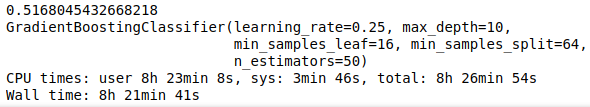

In [46]:
%%time

grid_pipe = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_pipe.fit(feature_train, target_train)
print(grid_pipe.best_score_)
print(grid_pipe.best_estimator_.steps[1][1])

/home/matu/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/matu/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/matu/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/matu/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/matu/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/matu/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarn

0.7988947539612331
LogisticRegression(C=10, penalty='l1', solver='liblinear')
CPU times: user 13min 42s, sys: 2min 2s, total: 15min 44s
Wall time: 11min 32s


In [44]:
grid_pipe.best_estimator_.fit(feature_train, target_train)
predictioRidgen = grid_pipe.best_estimator_.predict(feature_test)
accuracy_score(target_test, prediction)

0.8085424630214393

### 3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

The logistic regression model with the following hyperparameters proved to be the best:
 - LogisticRegression(C=10, penalty='l1', solver='liblinear')
 
The test sample did not show a strong difference from the result on the validation data. Which does not mean overfitting or underfitting.

The model is based on linear algebra. The algorithm works to reduce the overall predictive error.